In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
plt.rcParams["axes.grid"] = False
np.random.seed(1)

Using TensorFlow backend.


In [0]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [0]:
filelist_trainx = sorted(glob.glob('/content/drive/My Drive/images/*.png') , key=numericalSort)
filelist_trainy = sorted(glob.glob('/content/drive/My Drive/masks/*.png'), key=numericalSort)

In [0]:
img_arr1=list()
label_arr1=list()

In [0]:
for fname in filelist_trainx:
    img=Image.open(fname)
    size=(640,512)
    img=img.resize(size)
    img_arr=np.array(img)
    img_arr1.append(img_arr)

In [0]:
for fname in filelist_trainy:
    img=Image.open(fname)
    size=(640,512)
    img=img.resize(size)
    label_arr=np.array(img)
    label_arr1.append(label_arr)

In [0]:
X_train=np.array(img_arr1)
Y_train=np.array(label_arr1)

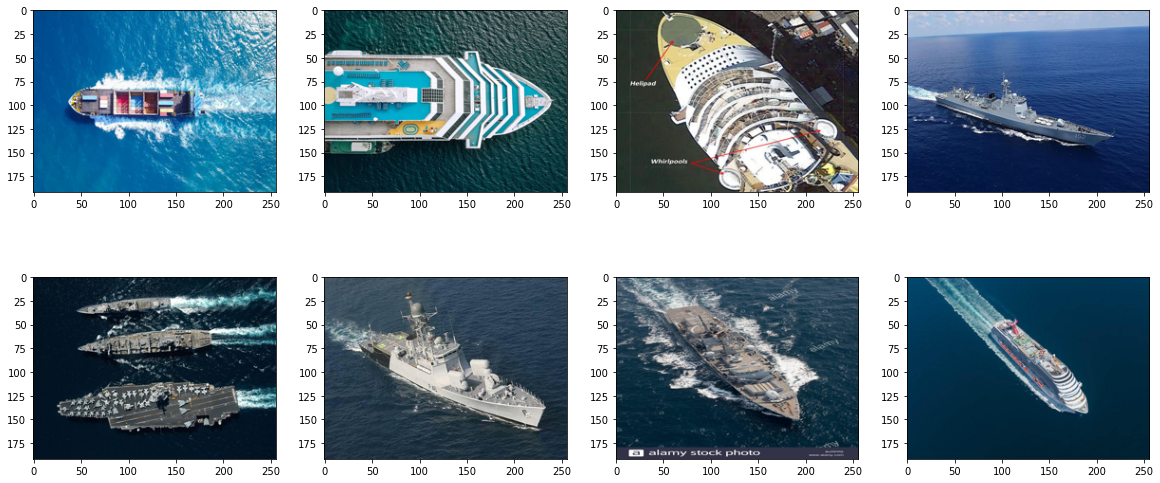

In [0]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(X_train[0])
plt.subplot(2,4,2)
plt.imshow(X_train[1])
plt.subplot(2,4,3)
plt.imshow(X_train[2])
plt.subplot(2,4,4)
plt.imshow(X_train[3])
plt.subplot(2,4,5)
plt.imshow(X_train[4])
plt.subplot(2,4,6)
plt.imshow(X_train[5])
plt.subplot(2,4,7)
plt.imshow(X_train[6])
plt.subplot(2,4,8)
plt.imshow(X_train[7])
plt.show()



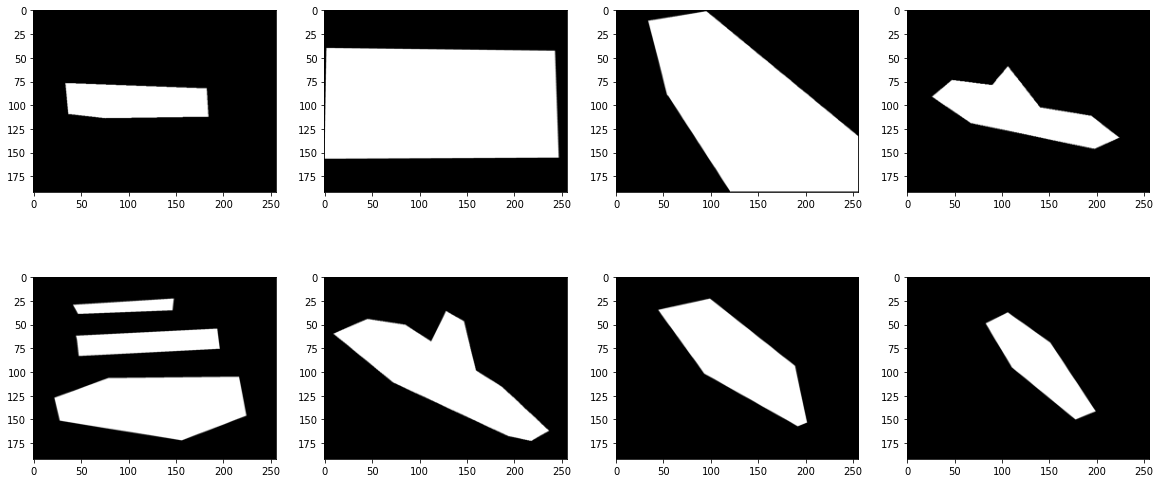

In [0]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(Y_train[0],cmap=plt.cm.binary_r)
plt.subplot(2,4,2)
plt.imshow(Y_train[1], cmap = plt.cm.binary_r)
plt.subplot(2,4,3)
plt.imshow(Y_train[2], cmap = plt.cm.binary_r)
plt.subplot(2,4,4)
plt.imshow(Y_train[3], cmap = plt.cm.binary_r)
plt.subplot(2,4,5)
plt.imshow(Y_train[4], cmap = plt.cm.binary_r)
plt.subplot(2,4,6)
plt.imshow(Y_train[5], cmap = plt.cm.binary_r)
plt.subplot(2,4,7)
plt.imshow(Y_train[6], cmap=plt.cm.binary_r)
plt.subplot(2,4,8)
plt.imshow(Y_train[7], cmap = plt.cm.binary_r)
plt.show()

In [0]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.1)

In [0]:
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac


In [0]:
def dice_coef(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [0]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [0]:
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


In [0]:
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))


In [0]:
def segnet(epochs_num,savename):

    # Encoding layer
    img_input = Input(shape= (192,256,3))
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)
    # Decoding Layer 
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    x = Activation('sigmoid')(x)
    pred = Reshape((192,256))(x)
    model = Model(inputs=img_input, outputs=pred)
    
    model.compile(optimizer=Adam(), loss= ["binary_crossentropy"],metrics=[iou, dice_coef, precision, recall, accuracy])
    model.summary()
    hist = model.fit(x_train, y_train, epochs= epochs_num, batch_size= 1, validation_data= (x_val, y_val), verbose=1)
    
    model.save(savename)
    return model,hist

In [0]:
model, hist = segnet(50, 'segnet2.h5')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 192, 256, 64)      1792      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 192, 256, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 192, 256, 64)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 192, 256, 64)      36928     
_________________________________________________________________
bn2 (BatchNormalization)     (None, 192, 256, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 192, 256, 64)      0     

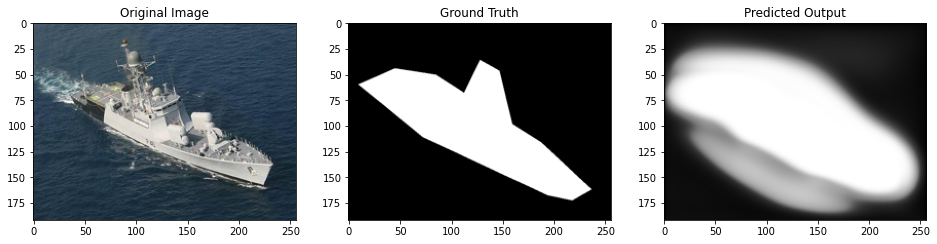

In [0]:
img_num = 16
img_pred = model.predict(x_train[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_train[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_train[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256),plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

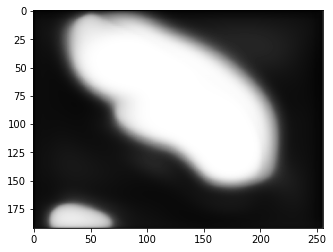

In [0]:
img_num =0
img_pred = model.predict(x_train[img_num].reshape(1,192,256,3))
plt.imshow(img_pred.reshape(192, 256),plt.cm.binary_r)